# **1. 라이브러리 호출**

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. 이미지 데이터 전처리 방법 정의**

In [21]:
class SemiconductorDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0]+'.png')
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        image = np.array(image)
        image = np.repeat(image[:, :, np.newaxis], 3, axis=2)  # Repeat grayscale image across three channels
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, img_id

# Transformation 정의
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# 모델 훈련 및 예측을 위한 데이터셋 정의
dir = '/content/drive/MyDrive/Colab Notebooks/data/open/'
train_dataset = SemiconductorDataset(csv_file=dir+'train.csv', root_dir=dir+'/train/', transform=transform)
test_dataset = SemiconductorDataset(csv_file=dir+'test.csv', root_dir=dir+'/test/', transform=transform)


# **3. 이미지 출력**

In [4]:
# 이미지 출력을 위한 함수 정의
def show_images(dataset, title):
    plt.figure(figsize=(10, 5))
    for i in range(6):
        image, _ = dataset[i]
        image = np.transpose(image.numpy(), (1, 2, 0))  # Convert to numpy and fix channel order for matplotlib
        ax = plt.subplot(2, 3, i + 1)
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"{title} {i}")
        plt.axis("off")
    plt.show()


## **3.1. 훈련 이미지 출력**

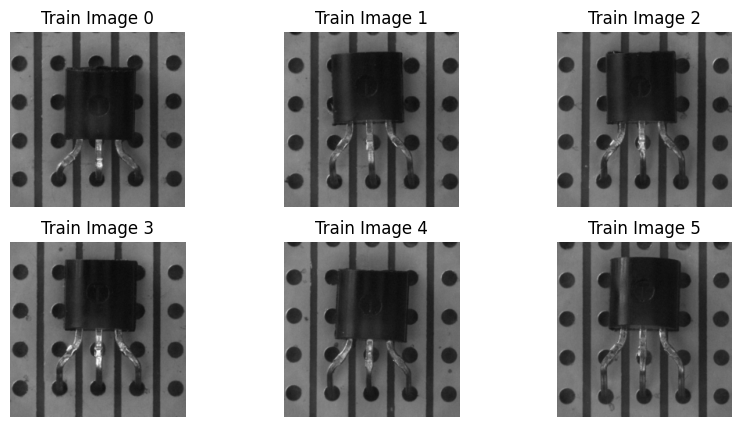

In [6]:
# 이미지 출력을 위한 transformation 정의
transform_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset_img = SemiconductorDataset(csv_file=dir+'train.csv', root_dir=dir+'/train/', transform=transform_img)

# 훈련 이미지 출력
show_images(train_dataset_img, "Train Image")

## **3.2. 테스트 이미지 출력**

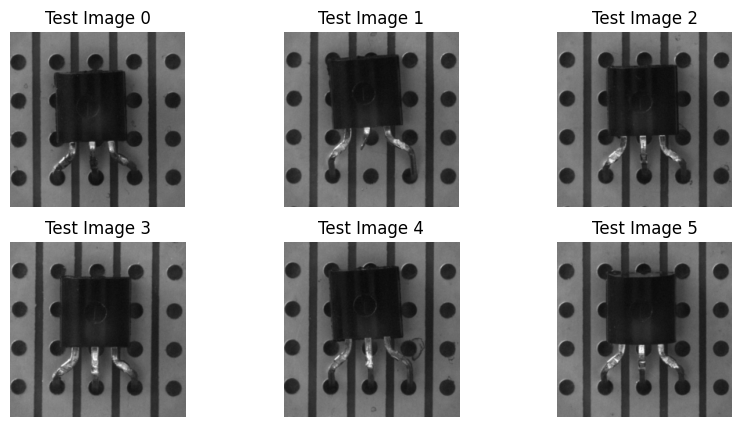

In [7]:
test_dataset_img = SemiconductorDataset(csv_file=dir+'test.csv', root_dir=dir+'/test/', transform=transform_img)

# 테스트 이미지 출력
show_images(test_dataset_img, "Test Image")

# **4. Pretrained ResNet18에서 특성 추출**

In [8]:
# Pretrained ResNet18 불러오기
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(in_features=resnet18.fc.in_features, out_features=2)

# 특성 추출
class FeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = torch.nn.Sequential(*(list(model.children())[:-1]))

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

feature_extractor = FeatureExtractor(resnet18).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


# **5. One-Class SVM 훈련**

In [22]:
# 이미지로부터 특성 추출하는 함수 정의
def get_features_from_images(dataset, model):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    features = []
    model.eval()
    with torch.no_grad():
        for image, _ in dataloader:
            image = image.to(device)
            feature = model(image).cpu().numpy()
            features.append(feature)
    return np.vstack(features)

# 특성 추출
train_features = get_features_from_images(train_dataset, feature_extractor)

# 특성 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)

# One-Class SVM 훈련
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.001).fit(X_train_scaled)
oc_svm.fit(X_train_scaled)


OneClassSVM(gamma='auto', nu=0.001)

In [23]:
# Extract features from the test set
test_features = get_features_from_images(test_dataset, feature_extractor)
test_features_scaled = scaler.transform(test_features)

# Predict using the trained One-Class SVM
test_preds = oc_svm.predict(test_features_scaled)

# Convert predictions to the required format: 0 for normal, 1 for abnormal
test_preds = (test_preds == -1).astype(int)

# Load sample submission file
sample_submission = pd.read_csv(dir+'sample_submission.csv')
sample_submission['label'] = test_preds

# Save the final predicted values
sample_submission.to_csv(dir+'final_submission.csv', index=False)

In [24]:
sample_submission

,id,label
0,TEST_000,1
1,TEST_001,1
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0
...,...,...
95,TEST_095,0
96,TEST_096,0
97,TEST_097,1
98,TEST_098,1
